# REINFORCE: Monte Carlo Policy Gradient

---

In this notebook, we will train REINFORCE with OpenAI Gym's [Cartpole-v0](https://github.com/openai/gym/wiki/CartPole-v0) environment.

In [1]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
from torch.distributions import Categorical

## 1 Setup CartPole Environment

**STATE:**

    [Cart Position,	        -2.4	   2.4
     Cart Velocity,	        -Inf	   Inf
     Pole Angle,	            ~-41.8°   ~41.8°
     Pole Velocity @ Tip]      -Inf	   Inf
    
**ACTION:**

    0	Push cart to the left
    1	Push cart to the right
    
**REWARD:**
    
    +1 for every step taken, including the termination step
    
**Episode Termination:**
    - Pole Angle > ±12°
    - Cart Position > ±2.4 (center of the cart reaches the edge of the display)
    - Episode length > 200 steps (500 for v1)
    
**Solved Requirements:**
        
     Considered solved when: (Average Return >= 195.0) for >100 consecutive trials

In [2]:
env = gym.make('CartPole-v0')
print('state space :', env.observation_space)
print('action space:', env.action_space)

state space : Box(4,)
action space: Discrete(2)


## 2 Define Architecture of Policy

In [3]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()        
        self.a_size = a_size
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, state):
        out = F.relu(self.fc1(state))
        out = self.fc2(out)        
        return F.softmax(out, dim=0) 
    
    def act(self, state):
        policy = self.forward(state)
        action = np.random.choice(range(self.a_size), p=policy.detach().cpu().numpy())
        return action, policy[action]

## 3 Train the Agent with REINFORCE

In [12]:
def reinforce(env, policy, optimizer, max_t=200, gamma=1.0, print_every=100, seed=27):
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    env.seed(seed)
        
    scores = []
    most_recent_100_scores = deque(maxlen=print_every)
    e=1    
    while e==1 or np.mean(most_recent_100_scores) < 195.:
        state = env.reset()
        G = []                  # store discounted rewards
        P = torch.zeros(max_t)  # store P(A_t|S_t)
               
        # Collect an episode
        for t in range(max_t):
            action, p = policy.act(torch.tensor(state).float().to(device))
            next_state, reward, done, _ = env.step(action)
            P[t] = p
            G.append(gamma**t*reward)
            if done:
                break               
            state = next_state
        
        scores.append(sum(G))
        most_recent_100_scores.append(sum(G))
                      
        # Update weights (EVERY episode)
        optimizer.zero_grad()
        G = torch.tensor([sum(G[t:]) for t in range(len(G))])  # Expected Return (Sum of FUTURE rewards)
        gradient_term = -torch.dot(G, torch.log(P[:len(G)]))
        gradient_term.backward()  # Calculate gradient
        optimizer.step() # Update weights

        if e%print_every == 0:
            print("Episode: {}\t Avg Score: {:.2f}".format(e, np.mean(most_recent_100_scores)))
        
        e += 1
   
    print("\nEnvironment Solved in {} episodes".format(e))
    
    return scores

In [13]:
policy = Policy(s_size=env.observation_space.shape[0], 
                a_size=env.action_space.n, 
                h_size=32).to(device)

optimizer = optim.Adam(policy.parameters(), lr=0.01)

In [8]:
scores = reinforce(env, policy)

Episode: 100	 Avg Score: 37.81
Episode: 200	 Avg Score: 84.83
Episode: 300	 Avg Score: 76.84
Episode: 400	 Avg Score: 132.90

Environment Solved in 450 episodes


## 4 Plot Scores

Text(0.5,0,'Episode')

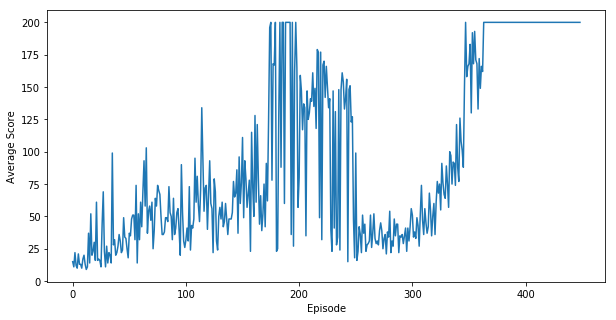

In [9]:
plt.figure(figsize=(10,5))
plt.plot(scores)
plt.ylabel('Average Score')
plt.xlabel('Episode')

## 5 Watch the Trained Agent

200.0
200.0
200.0


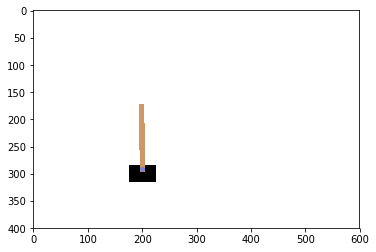

In [11]:
import time

for _ in range(3):
    state = env.reset()
    plt.imshow(env.render(mode='rgb_array'))
    score=0
    for t in range(1000):
        action, _ = policy.act(torch.tensor(state).float().to(device))
        plt.imshow(env.render(mode='rgb_array')) 
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            break
    print(score)
    time.sleep(1)
env.close()